# Part 4: XGBoost

For Part 4 of the Time Series Analysis, this notebook will look at XGBoosting. XGBoost is a type of model that utilizes a forest of decision trees to model data. This type of model is very powerful in modelling data, especially for classification, through the use of gradient boosting. For this notebook, XGBoost will be used for regression. 
The reference source for this advanced analysis can be found [here](https://towardsdatascience.com/machine-learning-techniques-applied-to-stock-price-prediction-6c1994da8001)

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np  
#I tooke the appl stock data and moved it into a more convient file location
pathToData = "StockData\AppleStock.txt"

#Check if there is a valid file in directory
if(os.path.isfile(pathToData)):
    print("Path Found")
    data = pd.read_csv(pathToData, sep=",")
else:
    print("Path Not Found")

Path Found


In [14]:
def get_moving_average_metrics(y_pred, y_true, MAE = True, MSE = True,Root_MSE = True):
    """
    Given a set of real and predicted data points, derive the common metrics of 
    Mean Absolute Error, Mean Square Erro, and Root Mean Square Error
    Params:
        y_pred   : predicted values
        y_true   : real data values
        MAE      : true or false to find MAE
        MSE      : true or false to find MSE
        Root_MSE : true or false to find Root_MSE
    """
    mae = 0.0
    if MAE:
        diff = 0
        for i in range(len(y_pred)):
            diff += abs(y_true[i] - y_pred[i])
        
        mae = diff / len(y_pred) 
    mse = 0.0
    if MSE: 
        diff = 0
        for i in range(len(y_pred)):
            diff += (y_true[i] - y_pred[i])**2
        mse = diff / len(y_pred)
    root_mse = 0.0
    if Root_MSE:
        diff = 0
        for i in range(len(y_pred)):
            diff += (y_true[i] - y_pred[i])**2
        root_mse = (diff / len(y_pred)) ** .5
    
    return mae, mse, root_mse

In [15]:
datesData = data["Date"].tolist()
openPriceData = data["Open"].tolist() 
closePricedata = data["Close"].tolist()

print(len(datesData))
frontSlice = 8364 - 3650
endSlice = 8364
trimDatesData = datesData[frontSlice:endSlice]
trimOpenPriceData = openPriceData[frontSlice:endSlice]
trimClosePriceData = closePricedata[frontSlice:endSlice]

8364


In [16]:
#The Dates are in the in a string format. For a linear regression analysis,
#the dates need to placed into numeric values. We can correspond the dates to
#numbers from 0 - endDate
numericDatesData = []
for i in range(len(trimDatesData)):
    numericDatesData.append([i])
numericDatesData = np.array(numericDatesData)

In [22]:
import xgboost as xgb
def create_XGBoost(model_seed = 0, 
                   n_tree_estimators = 100,
                   max_tree_depth = 3, 
                   learning_rate = .1, 
                   min_child_weight = 1, 
                   subsample=1,
                   colsample_bytree=1,
                   colsample_bylevel=1,
                   gamma = 0):
    """
    Create a XGboost model with the given simplified parameters
    Params:
        model_seed        : the seed for the model
        n_tree_estimators : the number of trees in the XG forest
        max_tree_depth    : the maximum depth of a given tree
        learning_rate     : the rate the model updates
        min_child_weight  : the minimum wieght that a given tree will have
        gamma             : minimum loss required before update occurs
    Returns:
        model : an XGboost model
    """
    
    model = xgb.XGBRegressor(seed = model_seed,
                         n_estimators = n_tree_estimators,
                         max_depth = max_tree_depth,
                         learning_rate = learning_rate,
                         min_child_weight = min_child_weight,
                         subsample=1,
                         colsample_bytree=1,
                         colsample_bylevel=1,
                         objective = "reg:squarederror",
                         gamma = gamma) 
    return model

def generate_preds(x_train, y_train, x_test, model):
    """
    From a given set of training and test data and a model, generate an array 
    predictions
    Params:
        x_train : set of x training data
        y_train : set of corresponding y data
        x_test  : set of x testing data
        model   : an XGboost model
        Returns:
        y_pred : a set of predictions
    """
    model.fit(x_train, y_train)
    y_preds = model.predict(x_test)
    return y_preds 

In [23]:
x_train, x_test, y_train, y_test = train_test_split(
        numericDatesData, trimOpenPriceData, test_size=.2, random_state=0)

model = create_XGBoost(model_seed = 0, 
                   n_tree_estimators = 100,
                   max_tree_depth = 30, 
                   learning_rate = .1, 
                   min_child_weight = .05, 
                   gamma = 0.1)
y_preds = generate_preds(x_train, y_train, x_test, model)
mae, mse, root_mse = get_moving_average_metrics(y_test, y_preds)

print("Mean Absolute Error:" , mae)
print("Mean Square Error:" , mse)
print("Root Mean Square Error:", root_mse)

Mean Absolute Error: 0.6057277876864388
Mean Square Error: 1.2899844184343117
Root Mean Square Error: 1.1357748097375253


In [ ]:
print(len(x_train_split))
print(len(y_train_split))
print(len(x_test_split))
print(len(y_test_split))

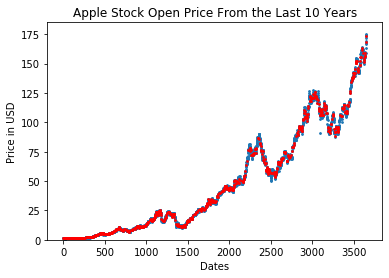

In [24]:
fig, ax = plt.subplots()
plt.scatter(numericDatesData, trimOpenPriceData, s = 3)
plt.scatter(x_test, y_preds, s = 3, color = "red")
plt.title("Apple Stock Open Price From the Last 10 Years")
plt.xlabel("Dates")
plt.ylabel("Price in USD")
plt.ylim(0, max(trimOpenPriceData) + 10)
plt.show()

In [25]:
#First, finetune the number of tree estimators
x_train, x_test, y_train, y_test = train_test_split(
        numericDatesData, trimOpenPriceData, test_size=.2, random_state=0)
comp_index = []
for treeNum in range(200):
    model = create_XGBoost(model_seed = 0, 
                   n_tree_estimators = treeNum,
                   max_tree_depth = 30, 
                   learning_rate = .1, 
                   min_child_weight = .05, 
                   gamma = 0.1)
    y_preds = generate_preds(x_train, y_train, x_test, model)
    mae, mse, root_mse = get_moving_average_metrics(y_test, y_preds)
    comp_index.append([treeNum, root_mse])

best_index = []
best_index = comp_index[0]  
for comp in comp_index:
    if best_index[1] > comp[1]:
        best_index = comp

print("Number of Trees:" , best_index[0])
print("Root Mean Square Error:", best_index[1])

Number of Trees: 61
Root Mean Square Error: 1.1186374894107498


In [28]:
numTrees = []
RMSE = []
for comp in comp_index:
    RMSE.append(comp[1])
    numTrees.append(comp[0])

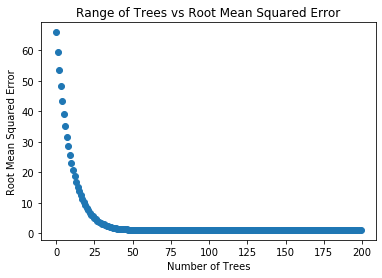

In [29]:
fig, ax = plt.subplots()
plt.scatter(numTrees, RMSE)
plt.title("Range of Trees vs Root Mean Squared Error")
plt.xlabel("Number of Trees")
plt.ylabel("Root Mean Squared Error")
plt.show()

The number of trees seem to be optimized at 61, and the RMSE converges to a singular value after 50.

In [30]:
#Second, finetune the number of tree depth.
#Since we know that number of tree converges, we can choose 61
x_train, x_test, y_train, y_test = train_test_split(
        numericDatesData, trimOpenPriceData, test_size=.2, random_state=0)
comp_index = []
for depth in range(200):
    model = create_XGBoost(model_seed = 0, 
                   n_tree_estimators = 61,
                   max_tree_depth = depth, 
                   learning_rate = .1, 
                   min_child_weight = .05, 
                   gamma = 0.1)
    y_preds = generate_preds(x_train, y_train, x_test, model)
    mae, mse, root_mse = get_moving_average_metrics(y_test, y_preds)
    comp_index.append([depth, root_mse])

best_index = []
best_index = comp_index[0]  
for comp in comp_index:
    if best_index[1] > comp[1]:
        best_index = comp

print("Depth:" , best_index[0])
print("Root Mean Square Error:", best_index[1])

Depth: 12
Root Mean Square Error: 1.1089568605732354


In [31]:
tree_depth = []
RMSE = []
for comp in comp_index:
    RMSE.append(comp[1])
    tree_depth.append(comp[0])

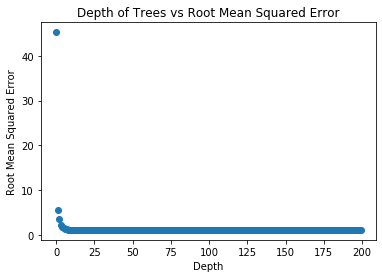

In [32]:
fig, ax = plt.subplots()
plt.scatter(tree_depth, RMSE)
plt.title("Depth of Trees vs Root Mean Squared Error")
plt.xlabel("Depth")
plt.ylabel("Root Mean Squared Error")
plt.show()

The number of trees seem to be optimized at 12, and the RMSE converges to a singular value after this value.

In [36]:
#Third, finetune the number of tree depth.
#Since we know that number of tree converges, we can choose 61
#Since we know that the depth converges at 12, we can hold it
x_train, x_test, y_train, y_test = train_test_split(
        numericDatesData, trimOpenPriceData, test_size=.2, random_state=0)
comp_index = []
for gamma in range(10):
    val = .1*gamma
    model = create_XGBoost(model_seed = 0, 
                   n_tree_estimators = 61,
                   max_tree_depth = depth, 
                   learning_rate = .1, 
                   min_child_weight = .05, 
                   gamma = val)
    y_preds = generate_preds(x_train, y_train, x_test, model)
    mae, mse, root_mse = get_moving_average_metrics(y_test, y_preds)
    comp_index.append([val, root_mse])

best_index = []
best_index = comp_index[0]  
for comp in comp_index:
    if best_index[1] > comp[1]:
        best_index = comp

print("Gamma:" , best_index[0])
print("Root Mean Square Error:", best_index[1])

Gamma: 0.9
Root Mean Square Error: 1.1135004439659684


In [37]:
Gamma = []
RMSE = []
for comp in comp_index:
    RMSE.append(comp[1])
    Gamma.append(comp[0])

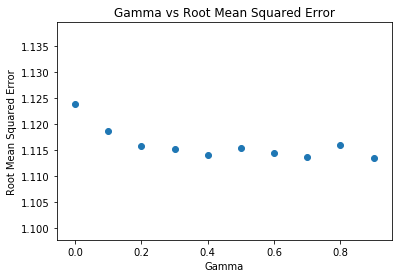

In [38]:
fig, ax = plt.subplots()
plt.scatter(Gamma, RMSE)
plt.title("Gamma vs Root Mean Squared Error")
plt.xlabel("Gamma")
plt.ylabel("Root Mean Squared Error")
plt.show()

The number of trees seem to be optimized at .4. After this value, gamma starts to osicillate

In [41]:
#Since we did a peliminary check on three hyperparameters. We can concentrate
#the values around the optimized values above. 
# Gamma will range around .3 to .5 
# Depth will range around 10 to 15
# Num of Trees will range 55 to 65
x_train, x_test, y_train, y_test = train_test_split(
        numericDatesData, trimOpenPriceData, test_size=.2, random_state=0)
gamma = [.3,.4,.5]
depth = [10,11,12,13,14,15]
numTrees = [55,56,57,58,58,59,60,61,62,63,64,65]
comp_index = []
for gam in gamma:
    for mdepth in depth:
        for treeCount in numTrees:
            model = create_XGBoost(model_seed = 0, 
                   n_tree_estimators = treeCount,
                   max_tree_depth = mdepth, 
                   learning_rate = .1, 
                   min_child_weight = .05, 
                   gamma = gam)
            y_preds = generate_preds(x_train, y_train, x_test, model)
            mae, mse, root_mse = get_moving_average_metrics(y_test, y_preds)
            comp_index.append([root_mse, gam, mdepth, treeCount])

best_index = []
best_index = comp_index[0]
for comp in comp_index:
    if best_index[0] > comp[0]:
        best_index = comp

print("Gamma:" , best_index[1])
print("Tree Depth:", best_index[2])
print("Tree Count:", best_index[3])
print("Root Mean Square Error:", best_index[0])            

Gamma: 0.3
Tree Depth: 13
Tree Count: 65
Root Mean Square Error: 1.1097621612365764


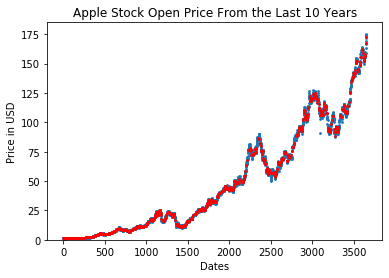

In [42]:
#Thus we have the final model with the best params above
TREE_COUNT = 65
TREE_DEPTH = 13
GAMMA = .3

x_train, x_test, y_train, y_test = train_test_split(
        numericDatesData, trimOpenPriceData, test_size=.2, random_state=0)
model = create_XGBoost(model_seed = 0, 
                   n_tree_estimators = TREE_COUNT,
                   max_tree_depth = TREE_DEPTH, 
                   learning_rate = .1, 
                   min_child_weight = .05, 
                   gamma = GAMMA)
y_preds = generate_preds(x_train, y_train, x_test, model)


fig, ax = plt.subplots()
plt.scatter(numericDatesData, trimOpenPriceData, s = 3)
plt.scatter(x_test, y_preds, s = 3, color = "red")
plt.title("Apple Stock Open Price From the Last 10 Years")
plt.xlabel("Dates")
plt.ylabel("Price in USD")
plt.ylim(0, max(trimOpenPriceData) + 10)
plt.show()

There is still are still limitations with the XGboost model. This model is based on a forest of desicion tree. As such, this model has a strong ability to determine the classification and regression of the dataset. However, the decision tree converges to a value after a certain threshold is past. This is due the decision forest gives the same values after the maximum of its dataset. 